## Обработка графиков ЭКГ и преобразование в таблицу

In [599]:
import pywt
import scipy
import os
from pylab import *
from numpy import*
import pandas as pd

import matplotlib.pyplot as plt
from peakdetect import peakdetect
from category_encoders.target_encoder import TargetEncoder

In [600]:
def get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [601]:
def gpu_get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = cp.asnumpy(cp.load(way).transpose().reshape((60000,)))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [602]:
def into_one_table(keys, directory): # преобразование графиков в таблицу
    row = get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [603]:
def gpu_into_one_table(keys, directory): # преобразование графиков в таблицу
    row = gpu_get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        #row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [604]:
%%time
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-2])))
ECG_data = into_one_table(target, 'train/') # таблица с графиками

CPU times: total: 8.75 s
Wall time: 9.56 s


In [605]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'record_name'})

In [606]:
ECG_data = ECG_data.sort_values(by=['record_name'], ascending=True)

In [607]:
gts = pd.read_csv('train/train_gts.csv')
gts.record_name = list(map(lambda x: int(x.strip('_hr')), gts.record_name))
gts

,record_name,myocard
0,669,0
1,209,0
2,777,0
3,1394,0
4,1618,0
...,...,...
2096,20864,0
2097,20967,0
2098,21744,0
2099,3465,0


In [608]:
ECG_data = ECG_data.merge(gts, on='record_name', how='left')
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,1875,1876,1877,1878,1879,1880,1881,1882,1883,myocard
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759,0
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243,0
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320,0
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437,0
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361,0
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573,0
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902,0
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710,0


In [609]:
df = pd.read_csv('train/train_meta.csv')

In [610]:
df = df.drop('record_name', axis=1)

In [611]:
df = df.rename(columns={'ecg_id': 'record_name'})

In [612]:
ECG_data = ECG_data.merge(df, on='record_name', how='left')

In [613]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,group
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,1
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,NaN,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,3
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,NaN,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,3
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,2
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/21000/21784_lr,records500/21000/21784_hr,3
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21795_lr,records500/21000/21795_hr,3
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,NaN,", alles,",NaN,NaN,NaN,NaN,3,records100/21000/21825_lr,records500/21000/21825_hr,1
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/21000/21831_lr,records500/21000/21831_hr,3


In [614]:
Myocard = ECG_data.myocard

In [615]:
ECG_data = ECG_data.drop(['myocard'], axis=1)

In [616]:
ECG_data_train, ECG_data_val, myocard_train, myocard_val = train_test_split(ECG_data, Myocard, random_state=0)

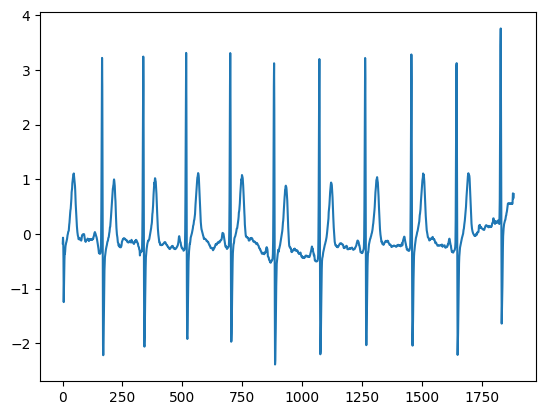

In [617]:
plt.plot(ECG_data.iloc[0, 1:-28]) # график экг после обработки сигнала

In [618]:
df_train = ECG_data_train.iloc[:, -28:]
df_val = ECG_data_val.iloc[:, -28:]

In [619]:
df_train

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,group
1592,4964.0,22.0,1,163.0,90.0,NaN,5.0,AT-6 C 5.5,1996-08-06 09:38:21,sinus tachycardia. otherwise normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/16000/16603_lr,records500/16000/16603_hr,1
918,16196.0,84.0,0,NaN,NaN,1.0,2.0,AT-60 3,1992-12-27 17:02:16,schrittmacher ekg 4.46 ...,...,NaN,NaN,NaN,NaN,NaN,"ja, pacemaker",10,records100/09000/09557_lr,records500/09000/09557_hr,3
122,767.0,61.0,0,183.0,83.0,8.0,1.0,AT-6 C 5.5,1988-04-10 12:42:59,"sinus rhythm. q waves in ii, iii, avf are prob...",...,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/01000/01511_lr,records500/01000/01511_hr,2
684,12056.0,74.0,1,NaN,NaN,1.0,2.0,CS-12,1991-10-08 09:34:18,sinusrhythmus lagetyp normal normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/07000/07125_lr,records500/07000/07125_hr,2
214,2452.0,60.0,1,152.0,NaN,3.0,1.0,AT-6 6,1988-10-03 11:16:50,sinus rhythm. normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/02000/02316_lr,records500/02000/02316_hr,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN,0.0,0.0,CS100 3,1993-07-27 13:38:26,sinusrhythmus lagetyp normal mÄssige amplitude...,...,"V4-V6,",", I-AVR,",NaN,NaN,NaN,NaN,1,records100/10000/10677_lr,records500/10000/10677_hr,1
1731,4102.0,64.0,1,168.0,66.0,7.0,1.0,AT-6 6,1997-06-30 11:09:34,sinus rhythm. left axis deviation. left anteri...,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/18000/18020_lr,records500/18000/18020_hr,2
763,10524.0,34.0,0,NaN,72.0,0.0,0.0,CS-12 E,1992-04-20 08:23:32,sinusrhythmus lagetyp normal normales ekg,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,3,records100/07000/07978_lr,records500/07000/07978_hr,2
835,10717.0,55.0,0,NaN,NaN,0.0,0.0,CS100 3,1992-08-17 09:50:58,sinusbradykardie linkstyp qrs(t) abnorm ant...,...,NaN,", I-AVF,",NaN,NaN,NaN,NaN,8,records100/08000/08797_lr,records500/08000/08797_hr,2


In [620]:
ECG_data_train = ECG_data_train.iloc[:, :-28]
ECG_data_val = ECG_data_val.iloc[:, :-28]

In [621]:
ECG_data_train

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1592,16603,0.109449,0.185223,0.125672,-0.151371,-0.829218,-0.622236,-0.656209,-0.655158,-0.620203,...,-0.276397,-0.271167,-0.271356,-0.278988,-0.276562,-0.365569,-0.453599,-0.369220,-0.385059,-0.441318
918,9557,-1.490900,-1.394463,-1.459593,-1.758585,-2.413724,-2.193418,-1.980952,-1.772527,-1.498688,...,1.808763,1.794004,1.791578,1.824338,1.824525,2.338546,2.856921,2.381495,2.466389,2.781295
122,1511,0.410295,0.418111,0.411441,0.385160,0.316728,0.322976,0.268045,0.196556,0.132210,...,0.429139,0.419976,0.423895,0.435734,0.434976,0.667413,0.897665,0.677479,0.718923,0.865508
684,7125,-0.121402,-0.121375,-0.120977,-0.119733,-0.114203,-0.115726,-0.117201,-0.126269,-0.128501,...,0.680528,0.667779,0.672897,0.689272,0.687265,0.994409,1.308699,1.007843,1.064270,1.265372
214,2316,0.028528,-0.025202,0.009788,0.172212,0.546162,0.536875,1.251363,2.411523,3.051960,...,-0.384466,-0.378909,-0.380860,-0.388554,-0.387973,-0.530641,-0.673326,-0.537565,-0.562936,-0.653343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,10677,1.348874,1.394465,1.405025,1.479370,1.920034,1.547778,0.474275,-0.755991,-1.562751,...,-0.187951,-0.184040,-0.186707,-0.190465,-0.189940,-0.280883,-0.378106,-0.283582,-0.301543,-0.365178
1731,18020,-0.285911,-0.265134,-0.282379,-0.365458,-0.574443,-0.503349,-0.498727,-0.482626,-0.459739,...,-0.247702,-0.239041,-0.247471,-0.255108,-0.257066,-0.526102,-0.801259,-0.535676,-0.586126,-0.763746
763,7978,-0.316812,-0.305549,-0.314139,-0.357382,-0.462342,-0.426322,-0.437142,-0.429418,-0.412790,...,-0.151037,-0.149981,-0.150161,-0.152364,-0.152745,-0.197529,-0.242362,-0.200993,-0.208471,-0.235857
835,8797,-0.897106,-0.901242,-0.897541,-0.887869,-0.862189,-0.857458,-0.841005,-0.826645,-0.800221,...,0.142141,0.140497,0.141669,0.143489,0.143677,0.191975,0.240699,0.193946,0.202788,0.233976


In [622]:
df_train

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,group
1592,4964.0,22.0,1,163.0,90.0,NaN,5.0,AT-6 C 5.5,1996-08-06 09:38:21,sinus tachycardia. otherwise normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/16000/16603_lr,records500/16000/16603_hr,1
918,16196.0,84.0,0,NaN,NaN,1.0,2.0,AT-60 3,1992-12-27 17:02:16,schrittmacher ekg 4.46 ...,...,NaN,NaN,NaN,NaN,NaN,"ja, pacemaker",10,records100/09000/09557_lr,records500/09000/09557_hr,3
122,767.0,61.0,0,183.0,83.0,8.0,1.0,AT-6 C 5.5,1988-04-10 12:42:59,"sinus rhythm. q waves in ii, iii, avf are prob...",...,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/01000/01511_lr,records500/01000/01511_hr,2
684,12056.0,74.0,1,NaN,NaN,1.0,2.0,CS-12,1991-10-08 09:34:18,sinusrhythmus lagetyp normal normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/07000/07125_lr,records500/07000/07125_hr,2
214,2452.0,60.0,1,152.0,NaN,3.0,1.0,AT-6 6,1988-10-03 11:16:50,sinus rhythm. normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/02000/02316_lr,records500/02000/02316_hr,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN,0.0,0.0,CS100 3,1993-07-27 13:38:26,sinusrhythmus lagetyp normal mÄssige amplitude...,...,"V4-V6,",", I-AVR,",NaN,NaN,NaN,NaN,1,records100/10000/10677_lr,records500/10000/10677_hr,1
1731,4102.0,64.0,1,168.0,66.0,7.0,1.0,AT-6 6,1997-06-30 11:09:34,sinus rhythm. left axis deviation. left anteri...,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/18000/18020_lr,records500/18000/18020_hr,2
763,10524.0,34.0,0,NaN,72.0,0.0,0.0,CS-12 E,1992-04-20 08:23:32,sinusrhythmus lagetyp normal normales ekg,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,3,records100/07000/07978_lr,records500/07000/07978_hr,2
835,10717.0,55.0,0,NaN,NaN,0.0,0.0,CS100 3,1992-08-17 09:50:58,sinusbradykardie linkstyp qrs(t) abnorm ant...,...,NaN,", I-AVF,",NaN,NaN,NaN,NaN,8,records100/08000/08797_lr,records500/08000/08797_hr,2


## N-граммы

In [643]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [528]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [529]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [530]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [531]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [532]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [533]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [534]:
ECG_data_array_train = np.array(ECG_data_train)

In [535]:
R_Peaks_train = []

In [536]:
ecg_ids_train = []
encoding_ecgs_train = []

In [537]:
for ecgsignal in ECG_data_array_train: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_train.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_train.append(ecg_id)
    encoding_ecgs_train.append(encoding_ecg)

In [538]:
encoding_ecg_train = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'myocard'])
encoding_ecg_train.encoding_ecg = encoding_ecgs_train
encoding_ecg_train.ecg_id = ecg_ids_train
encoding_ecg_train = encoding_ecg_train.sort_values(by='ecg_id')
encoding_ecg_train.myocard = array(myocard_train)
encoding_ecg_train

,encoding_ecg,ecg_id,myocard
1027,DDCADDCC,9.0,0
189,BFABCFADDEC,43.0,0
1064,DDEFBCCBCCF,52.0,0
43,DDCADBCDD,57.0,0
1110,FFCCFDCFDA,96.0,0
...,...,...,...
365,EBDCEBDCEB,21756.0,0
181,BCEFCCDDFAF,21774.0,0
344,AEDDDCCD,21775.0,0
1389,ECCDDDECB,21825.0,1


In [539]:
array(encoding_ecg_train)

array([['DDCADDCC', 9.0, 0],
       ['BFABCFADDEC', 43.0, 0],
       ['DDEFBCCBCCF', 52.0, 0],
       ...,
       ['AEDDDCCD', 21775.0, 0],
       ['ECCDDDECB', 21825.0, 1],
       ['DAFCCDDDCFCD', 21831.0, 0]], dtype=object)

In [540]:
sick = encoding_ecg_train[encoding_ecg_train.myocard == 1].encoding_ecg  # закодированные кардиограммы больных
healthy = encoding_ecg_train[encoding_ecg_train.myocard == 0].encoding_ecg  # закодированные кардиограммы здоровых

In [541]:
sp_sick= []  # список N-грамм больных
for i in sick:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_sick.append(k)

In [542]:
sp_healthy = []  # список N-грамм здоровых
for i in healthy:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_healthy.append(k)

In [543]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [544]:
q_sick = counter_and_sort(sp_sick) # отсортированные н-граммы больных
q_health = counter_and_sort(sp_healthy)  # отсортированные н-граммы здоровых

In [545]:
only_sick = list(set(q_sick.index) - set(q_health.index)) # н-граммы, встречающиеся только у больных
only_health = list(set(q_health.index) - set(q_sick.index)) # н-граммы, встречающиеся только у здоровых

In [546]:
popular_sick = q_sick.iloc[:len(q_sick) // 2] # н-граммы, чаще всего встречающиеся у больных
popular_health = q_health.iloc[:len(q_health) // 2] # н-граммы, чаще всего встречающиеся у здоровых

In [547]:
# н-граммы, которые чаще всего встречаются у больных и не встречаются у здоровых
popular_sick_only = list(set(popular_sick.index) - set(popular_health.index))

# н-граммы, которые чаще всего встречаются у здоровых и не встречаются у больных
popular_health_only = list(set(popular_health.index) - set(popular_sick.index))

In [548]:
ngramms_ecgs_train = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_train):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs_train.append(list(ngramms_ecg))

In [549]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    ng_health = sum(list(map(lambda x: 1 if x in only_health else 0, ng)))
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))

    ng_popular_health = sum(list(map(lambda x: 1 if x in popular_health_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))

    return [ng_health, ng_sick, ng_popular_health, ng_popular_sick]

In [550]:
arr_train = pd.DataFrame([func(ng) for ng in ngramms_ecgs_train])

In [551]:
X_train, X_test, y_train, y_test = train_test_split(arr_train, myocard_train, random_state=0, test_size=0.75)
# разбиение на тестовый и тренировочный датасет

In [552]:
cat_n_gramms = CatBoostClassifier(depth=9,  learning_rate=0.03)
cat_n_gramms.fit(X_train, y_train)

0:	learn: 0.6531258	total: 2.35ms	remaining: 2.35s
1:	learn: 0.6158396	total: 3.32ms	remaining: 1.66s
2:	learn: 0.5786680	total: 5.38ms	remaining: 1.79s
3:	learn: 0.5373107	total: 7.89ms	remaining: 1.96s
4:	learn: 0.5037379	total: 10ms	remaining: 2s
5:	learn: 0.4782898	total: 10.9ms	remaining: 1.8s
6:	learn: 0.4575646	total: 11.6ms	remaining: 1.65s
7:	learn: 0.4291645	total: 12.4ms	remaining: 1.54s
8:	learn: 0.4092066	total: 14ms	remaining: 1.54s
9:	learn: 0.3858795	total: 16.1ms	remaining: 1.6s
10:	learn: 0.3586992	total: 19ms	remaining: 1.71s
11:	learn: 0.3396584	total: 21.7ms	remaining: 1.79s
12:	learn: 0.3253194	total: 23.2ms	remaining: 1.76s
13:	learn: 0.3087882	total: 24.7ms	remaining: 1.74s
14:	learn: 0.2944310	total: 26.1ms	remaining: 1.71s
15:	learn: 0.2841580	total: 27.5ms	remaining: 1.69s
16:	learn: 0.2756273	total: 28.9ms	remaining: 1.67s
17:	learn: 0.2632382	total: 30.9ms	remaining: 1.69s
18:	learn: 0.2530861	total: 32.6ms	remaining: 1.68s
19:	learn: 0.2432993	total: 34.6m

273:	learn: 0.1182061	total: 391ms	remaining: 1.03s
274:	learn: 0.1181784	total: 392ms	remaining: 1.03s
275:	learn: 0.1181473	total: 393ms	remaining: 1.03s
276:	learn: 0.1181353	total: 394ms	remaining: 1.03s
277:	learn: 0.1181043	total: 396ms	remaining: 1.03s
278:	learn: 0.1180951	total: 397ms	remaining: 1.03s
279:	learn: 0.1180651	total: 399ms	remaining: 1.02s
280:	learn: 0.1180542	total: 400ms	remaining: 1.02s
281:	learn: 0.1180335	total: 402ms	remaining: 1.02s
282:	learn: 0.1180113	total: 404ms	remaining: 1.02s
283:	learn: 0.1179912	total: 404ms	remaining: 1.02s
284:	learn: 0.1179651	total: 405ms	remaining: 1.02s
285:	learn: 0.1179331	total: 406ms	remaining: 1.01s
286:	learn: 0.1179099	total: 407ms	remaining: 1.01s
287:	learn: 0.1178833	total: 408ms	remaining: 1.01s
288:	learn: 0.1178657	total: 410ms	remaining: 1.01s
289:	learn: 0.1178327	total: 411ms	remaining: 1s
290:	learn: 0.1178138	total: 412ms	remaining: 1s
291:	learn: 0.1177854	total: 413ms	remaining: 1s
292:	learn: 0.1177670

521:	learn: 0.1164105	total: 790ms	remaining: 723ms
522:	learn: 0.1164084	total: 791ms	remaining: 721ms
523:	learn: 0.1164066	total: 792ms	remaining: 720ms
524:	learn: 0.1164046	total: 794ms	remaining: 718ms
525:	learn: 0.1164027	total: 796ms	remaining: 717ms
526:	learn: 0.1164007	total: 797ms	remaining: 716ms
527:	learn: 0.1163985	total: 799ms	remaining: 715ms
528:	learn: 0.1163965	total: 801ms	remaining: 713ms
529:	learn: 0.1163947	total: 803ms	remaining: 712ms
530:	learn: 0.1163927	total: 805ms	remaining: 711ms
531:	learn: 0.1163903	total: 806ms	remaining: 709ms
532:	learn: 0.1163883	total: 808ms	remaining: 708ms
533:	learn: 0.1163864	total: 810ms	remaining: 707ms
534:	learn: 0.1163845	total: 811ms	remaining: 705ms
535:	learn: 0.1163828	total: 813ms	remaining: 703ms
536:	learn: 0.1163808	total: 814ms	remaining: 702ms
537:	learn: 0.1163791	total: 815ms	remaining: 700ms
538:	learn: 0.1163773	total: 817ms	remaining: 699ms
539:	learn: 0.1163756	total: 818ms	remaining: 697ms
540:	learn: 

708:	learn: 0.1161442	total: 1.61s	remaining: 660ms
709:	learn: 0.1161433	total: 1.61s	remaining: 659ms
710:	learn: 0.1161422	total: 1.62s	remaining: 658ms
711:	learn: 0.1161412	total: 1.62s	remaining: 656ms
712:	learn: 0.1161402	total: 1.63s	remaining: 655ms
713:	learn: 0.1161390	total: 1.63s	remaining: 654ms
714:	learn: 0.1161381	total: 1.64s	remaining: 652ms
715:	learn: 0.1161369	total: 1.64s	remaining: 651ms
716:	learn: 0.1161359	total: 1.65s	remaining: 649ms
717:	learn: 0.1161351	total: 1.65s	remaining: 648ms
718:	learn: 0.1161343	total: 1.65s	remaining: 647ms
719:	learn: 0.1161332	total: 1.66s	remaining: 645ms
720:	learn: 0.1161323	total: 1.66s	remaining: 644ms
721:	learn: 0.1161312	total: 1.67s	remaining: 642ms
722:	learn: 0.1161302	total: 1.67s	remaining: 641ms
723:	learn: 0.1161293	total: 1.68s	remaining: 640ms
724:	learn: 0.1161284	total: 1.68s	remaining: 638ms
725:	learn: 0.1161275	total: 1.69s	remaining: 637ms
726:	learn: 0.1161264	total: 1.69s	remaining: 635ms
727:	learn: 

883:	learn: 0.1160048	total: 2.43s	remaining: 319ms
884:	learn: 0.1160041	total: 2.44s	remaining: 317ms
885:	learn: 0.1160034	total: 2.44s	remaining: 314ms
886:	learn: 0.1160027	total: 2.45s	remaining: 312ms
887:	learn: 0.1160022	total: 2.45s	remaining: 309ms
888:	learn: 0.1160017	total: 2.46s	remaining: 307ms
889:	learn: 0.1160011	total: 2.46s	remaining: 304ms
890:	learn: 0.1160005	total: 2.47s	remaining: 302ms
891:	learn: 0.1159998	total: 2.47s	remaining: 300ms
892:	learn: 0.1159994	total: 2.48s	remaining: 297ms
893:	learn: 0.1159989	total: 2.48s	remaining: 294ms
894:	learn: 0.1159982	total: 2.49s	remaining: 292ms
895:	learn: 0.1159977	total: 2.49s	remaining: 289ms
896:	learn: 0.1159971	total: 2.5s	remaining: 287ms
897:	learn: 0.1159963	total: 2.5s	remaining: 284ms
898:	learn: 0.1159955	total: 2.51s	remaining: 282ms
899:	learn: 0.1159951	total: 2.51s	remaining: 279ms
900:	learn: 0.1159945	total: 2.52s	remaining: 276ms
901:	learn: 0.1159940	total: 2.52s	remaining: 274ms
902:	learn: 0.

In [553]:
f1_score(y_test, cat_n_gramms.predict(X_test), average='macro')

0.902781661759142

In [554]:
f1_score(y_train, cat_n_gramms.predict(X_train), average='macro')

0.9265380174830942

## Анализ HRV сигнала

In [555]:
hrv_data = pd.DataFrame(columns=['M', 'sco', 'coefficient_cov', 'amplitude', 'y'])
#создание датафрейма со статистическими показателями сигнала

In [556]:
hrv_data.y = myocard_train

In [557]:
RR = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks_train))

In [558]:
M = list(map(lambda rr: rr.mean(), RR)) #подсчёт математического ожидания

In [559]:
hrv_data.M = M

(array([236.,  28.,  11.,   9.,   6.,   4.,   7.,   0.,   1.,   4.]),
 array([2.53173721e-01, 3.09677672e+05, 6.19355092e+05, 9.29032511e+05,
        1.23870993e+06, 1.54838735e+06, 1.85806477e+06, 2.16774219e+06,
        2.47741961e+06, 2.78709703e+06, 3.09677445e+06]),
 <BarContainer object of 10 artists>)

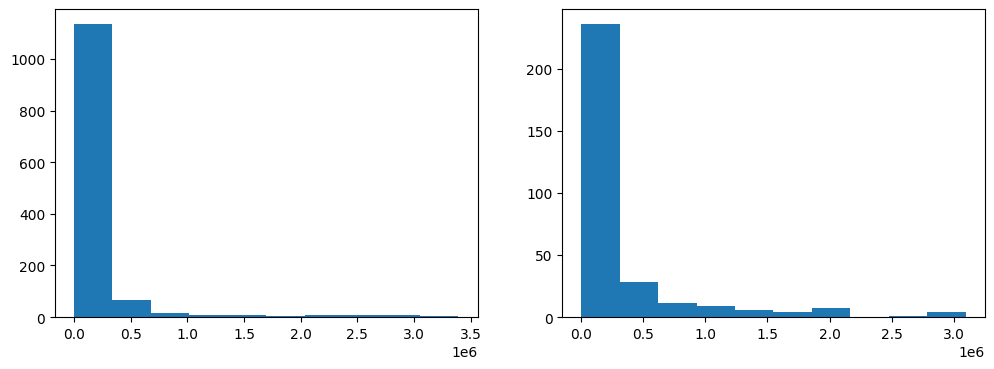

In [560]:
fig, axes = plt.subplots(1, 2, figsize = (12,4)) #построение графиков для сравнения математического ожидания у больных

axes[0].hist(hrv_data.M[hrv_data.y == 0])
axes[1].hist(hrv_data.M[hrv_data.y == 1])
#как видно, особых различий в распределении у больных и здоровых нет

In [561]:
def analysis_mat_expectation(M): #кодирование математического ожидания
    if M < 0.5:
        return 0
    elif 0.5 <= M < 0.66:
        return 1
    elif 0.66 <= M:
        return 2

In [562]:
hrv_data.M = list(map(lambda m: analysis_mat_expectation(m), M))

In [563]:
def moda_and_amplitude(peaks): #функция подсчёта моды и амплитуды
    eps = 0.02

    f = np.zeros(len(peaks))
    count_mode = np.zeros(len(peaks))

    for i in range(len(peaks) - 1):
        f[i] = (peaks[i + 1] - peaks[i])

    for m in range(len(f)):
        count = 0

        for t in range(len(f) - 1):
            if fabs(f[t + 1] - f[m]) / 100 < eps:
                count += 1

        count_mode[m] = count
    max = len(peaks) - 1

    for m in range(len(count_mode)):
        if count_mode[max] < count_mode[m]:
            max = m

    def amplitude_mode():
        return 100 * count_mode[max] / len(peaks)

    return amplitude_mode()

In [564]:
def analysis_amplitude(amplitude): #кодирование амплитуды

    if 65 <= amplitude < 100:
        return 0
    else:
        return 1

In [565]:
amplitude = list(map(lambda rpeaks: moda_and_amplitude(rpeaks), R_Peaks_train))

In [566]:
hrv_data.amplitude = amplitude

(array([20., 59., 52., 53., 39., 26., 23., 12., 14.,  8.]),
 array([ 8.33333333, 16.44736842, 24.56140351, 32.6754386 , 40.78947368,
        48.90350877, 57.01754386, 65.13157895, 73.24561404, 81.35964912,
        89.47368421]),
 <BarContainer object of 10 artists>)

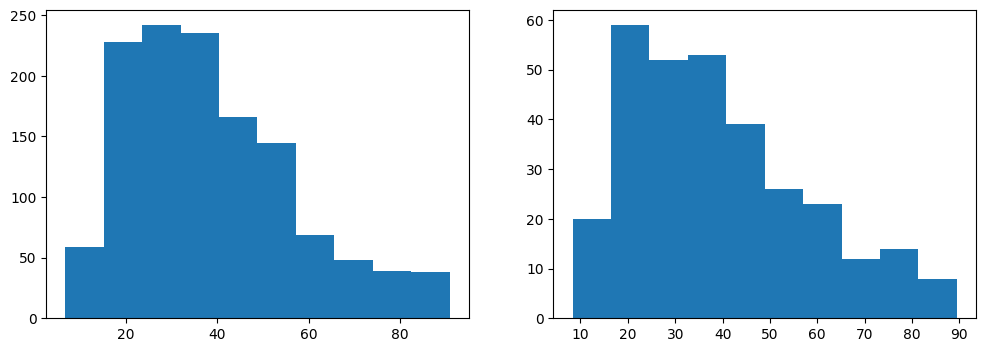

In [567]:
fig, axes = plt.subplots(1, 2, figsize = (12,4)) #графики для сравнения амплитуды у больных и здоровых

axes[0].hist(hrv_data.amplitude[hrv_data.y == 0])
axes[1].hist(hrv_data.amplitude[hrv_data.y == 1])
#распределение у обеих групп совпадает и особых различий нет

In [568]:
hrv_data.amplitude = list(map(lambda a: analysis_amplitude(a), amplitude))

In [569]:
def SCO(array, index): #функция для подсчёта среднего квадратичного отклонения
  global ECG_data_array
  R_values = [ECG_data_array[index][j] for j in array]
  n = len(R_values)
  mean = np.array(R_values).mean()
  summ = sum([(i - mean) ** 2 for i in R_values])
  return (summ / (n - 1)) ** 0.5

In [570]:
sco_values = [SCO(R_Peaks_train[i], i) for i in range(len(R_Peaks_train))]
hrv_data.sco = sco_values

(array([305.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.78079950e-02, 1.02959816e+02, 2.05901824e+02, 3.08843831e+02,
        4.11785839e+02, 5.14727847e+02, 6.17669855e+02, 7.20611863e+02,
        8.23553870e+02, 9.26495878e+02, 1.02943789e+03]),
 <BarContainer object of 10 artists>)

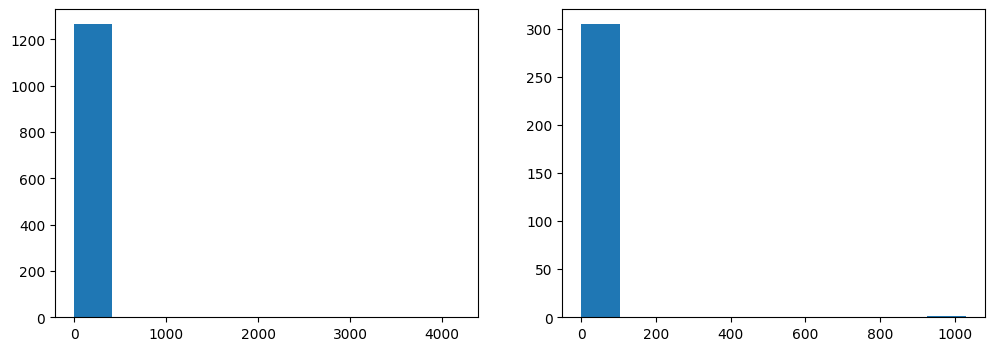

In [571]:
fig, axes = plt.subplots(1, 2, figsize = (12,4)) #графики для сравнения амплитуды у больных и здоровых

axes[0].hist(hrv_data.sco[hrv_data.y == 0])
axes[1].hist(hrv_data.sco[hrv_data.y == 1])
#графики схожи и их них нельзя получить достаточно информации о различии sco у больных и здоровых

In [572]:
def coefficient_covariance(M, SCO):
    return 100 * array(SCO) / array(M)

In [573]:
coefficient_covariance = coefficient_covariance(M, sco_values)

In [574]:
hrv_data.coefficient_cov = coefficient_covariance

In [575]:
hrv_data

,M,sco,coefficient_cov,amplitude,y
1592,1,0.838016,143.143259,1,0
918,0,0.498937,115.148244,0,0
122,0,1.162083,397.254966,1,0
684,0,0.990063,273.449054,0,0
214,0,0.070934,19.777696,1,0
...,...,...,...,...,...
1033,0,0.707767,190.996743,1,0
1731,0,0.800240,218.555700,1,0
763,0,0.405020,135.808956,1,0
835,2,0.528511,0.000132,1,1


## Анализ метаданных

In [576]:
df_train

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,group
1592,4964.0,22.0,1,163.0,90.0,NaN,5.0,AT-6 C 5.5,1996-08-06 09:38:21,sinus tachycardia. otherwise normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/16000/16603_lr,records500/16000/16603_hr,1
918,16196.0,84.0,0,NaN,NaN,1.0,2.0,AT-60 3,1992-12-27 17:02:16,schrittmacher ekg 4.46 ...,...,NaN,NaN,NaN,NaN,NaN,"ja, pacemaker",10,records100/09000/09557_lr,records500/09000/09557_hr,3
122,767.0,61.0,0,183.0,83.0,8.0,1.0,AT-6 C 5.5,1988-04-10 12:42:59,"sinus rhythm. q waves in ii, iii, avf are prob...",...,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/01000/01511_lr,records500/01000/01511_hr,2
684,12056.0,74.0,1,NaN,NaN,1.0,2.0,CS-12,1991-10-08 09:34:18,sinusrhythmus lagetyp normal normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/07000/07125_lr,records500/07000/07125_hr,2
214,2452.0,60.0,1,152.0,NaN,3.0,1.0,AT-6 6,1988-10-03 11:16:50,sinus rhythm. normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/02000/02316_lr,records500/02000/02316_hr,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN,0.0,0.0,CS100 3,1993-07-27 13:38:26,sinusrhythmus lagetyp normal mÄssige amplitude...,...,"V4-V6,",", I-AVR,",NaN,NaN,NaN,NaN,1,records100/10000/10677_lr,records500/10000/10677_hr,1
1731,4102.0,64.0,1,168.0,66.0,7.0,1.0,AT-6 6,1997-06-30 11:09:34,sinus rhythm. left axis deviation. left anteri...,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/18000/18020_lr,records500/18000/18020_hr,2
763,10524.0,34.0,0,NaN,72.0,0.0,0.0,CS-12 E,1992-04-20 08:23:32,sinusrhythmus lagetyp normal normales ekg,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,3,records100/07000/07978_lr,records500/07000/07978_hr,2
835,10717.0,55.0,0,NaN,NaN,0.0,0.0,CS100 3,1992-08-17 09:50:58,sinusbradykardie linkstyp qrs(t) abnorm ant...,...,NaN,", I-AVF,",NaN,NaN,NaN,NaN,8,records100/08000/08797_lr,records500/08000/08797_hr,2


In [577]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1575 entries, 1592 to 1653
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    1575 non-null   float64
 1   age                           1575 non-null   float64
 2   sex                           1575 non-null   int64  
 3   height                        514 non-null    float64
 4   weight                        683 non-null    float64
 5   nurse                         1456 non-null   float64
 6   site                          1574 non-null   float64
 7   device                        1575 non-null   object 
 8   recording_date                1575 non-null   object 
 9   report                        1575 non-null   object 
 10  scp_codes                     1575 non-null   object 
 11  heart_axis                    932 non-null    object 
 12  infarction_stadium1           382 non-null    object 
 13  infar

In [578]:
combo_info = df_train['weight'].astype(str) + '_' + df_train['height'].astype(str) \
    + '_' + df_train['age'].astype(str) + '_' + df_train['sex'].astype(str)
df_train.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

target_encoder_combo_info = TargetEncoder()
target_encoder_combo_info.fit(df_train.combo_info, myocard_train)
target_encoded_combo_info = target_encoder_combo_info.transform(df_train.combo_info)
df_train.combo_info = target_encoded_combo_info.astype('float')
#кодирование категориальных данных

In [579]:
target_encoder_scp_codes = TargetEncoder()
target_encoder_scp_codes.fit(df_train.scp_codes, myocard_train)
target_encoded_scp_codes = target_encoder_scp_codes.transform(df_train.scp_codes)
df_train.scp_codes = target_encoded_scp_codes.astype('float')
#стандарт для обмена цифровыми ЭКГ

In [580]:
target_encoder_i_s1 = TargetEncoder()
target_encoder_i_s1.fit(df_train.infarction_stadium1, myocard_train)
target_encoded_i_s1 = target_encoder_i_s1.transform(df_train.infarction_stadium1)
df_train.infarction_stadium1 = target_encoded_i_s1.astype('float')
#первая стадия инфаркта

target_encoder_i_s2 = TargetEncoder()
target_encoder_i_s2.fit(df_train.infarction_stadium2, myocard_train)
target_encoded_i_s2  = target_encoder_i_s2.transform(df_train.infarction_stadium2)
df_train.infarction_stadium2 = target_encoded_i_s2.astype('float')
#вторая стадия инфаркта

In [581]:
oft_value1 = df_train['heart_axis'].value_counts().idxmax()
df_train['heart_axis'] = df_train['heart_axis'].fillna(oft_value1) #заполнение NaN наиболее встречающимся значением

target_encoder_heart_axis = TargetEncoder()
target_encoder_heart_axis.fit(df_train.heart_axis, myocard_train)
target_encoded_heart_axis = target_encoder_heart_axis.transform(df_train.heart_axis)
df_train.heart_axis = target_encoded_heart_axis.astype('float')
#электрическая ось сердца

In [582]:
target_encoder_device = TargetEncoder()
target_encoder_device.fit(df_train.device, myocard_train)
target_encoded_device = target_encoder_device.transform(df_train.device)
df_train.device = target_encoded_device.astype('float')
#устройство записи

In [583]:
target_encoder_report = TargetEncoder()
target_encoder_report.fit(df_train.report, myocard_train)
target_encoded_report = target_encoder_report.transform(df_train.report)
df_train.report = target_encoded_report.astype('float')
#устройство записи

In [584]:
target_encoder_extra_beats = TargetEncoder()
target_encoder_extra_beats.fit(df_train.extra_beats, myocard_train)
target_encoded_extra_beats = target_encoder_extra_beats.transform(df_train.extra_beats)
df_train.extra_beats = target_encoded_extra_beats.astype('float')
#дополнительные удары сердца(обычно никак не влияют на здоров/болен)

In [585]:
target_encoder_pacemaker = TargetEncoder()
target_encoder_pacemaker.fit(df_train.pacemaker, myocard_train)
target_encoded_pacemaker = target_encoder_pacemaker.transform(df_train.pacemaker)
df_train.pacemaker = target_encoded_pacemaker.astype('float')
#кардиостимулятор(регулирует функцию электрической проводящей системы сердца)

In [586]:
oft_value2 = df_train['nurse'].value_counts().idxmax() #"номер" медсестры
df_train['nurse'] = df_train['nurse'].fillna(oft_value2)

oft_value3 = df_train['validated_by'].value_counts().idxmax() #"номер" утверждающего кардиолога
df_train['validated_by'] = df_train['validated_by'].fillna(oft_value3)

oft_value4 = df_train['site'].value_counts().idxmax() #"номер" сайта записи
df_train['site'] = df_train['site'].fillna(oft_value4)

In [587]:
df_train.drop(['recording_date', 'filename_lr', 'filename_hr',
         'age', 'sex', 'height', 'weight',
        'static_noise', 'burst_noise', 'electrodes_problems', 'baseline_drift'], axis= 1 , inplace= True )
#удаление ненужных строк, в том числе содержащих различные шумы

In [588]:
df_train.head()

,combo_info,patient_id,nurse,site,device,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,extra_beats,pacemaker,strat_fold,group
1592,0.169007,4964.0,0.0,5.0,0.176080,0.158843,0.125442,0.137615,0.04694,0.191449,2.0,False,False,True,0.193906,0.197292,10,1
918,0.203645,16196.0,1.0,2.0,0.130907,0.106825,0.087461,0.137615,0.04694,0.191449,1.0,False,True,True,0.193906,0.082680,10,3
122,0.169007,767.0,8.0,1.0,0.176080,0.166726,0.164275,0.137615,0.04694,0.191449,0.0,False,False,True,0.193906,0.197292,3,2
684,0.173514,12056.0,1.0,2.0,0.198697,0.010509,0.020089,0.137615,0.04694,0.191449,1.0,False,False,True,0.193906,0.197292,5,2
214,0.169007,2452.0,3.0,1.0,0.217105,0.039686,0.020089,0.137615,0.04694,0.191449,0.0,False,False,True,0.193906,0.197292,7,1


In [590]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1575 entries, 1592 to 1653
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   combo_info                    1575 non-null   float64
 1   patient_id                    1575 non-null   float64
 2   nurse                         1575 non-null   float64
 3   site                          1575 non-null   float64
 4   device                        1575 non-null   float64
 5   report                        1575 non-null   float64
 6   scp_codes                     1575 non-null   float64
 7   heart_axis                    1575 non-null   float64
 8   infarction_stadium1           1575 non-null   float64
 9   infarction_stadium2           1575 non-null   float64
 10  validated_by                  1575 non-null   float64
 11  second_opinion                1575 non-null   bool   
 12  initial_autogenerated_report  1575 non-null   bool   
 13  valid

In [593]:
X_train, X_test, y_train, y_test = train_test_split(df_train, myocard_train, test_size=0.1, random_state=0)

In [594]:
cat_meta = CatBoostClassifier(depth=8,  learning_rate=0.05)
cat_meta.fit(X_train, y_train)

0:	learn: 0.5977246	total: 4.73ms	remaining: 4.72s
1:	learn: 0.5199137	total: 5.92ms	remaining: 2.95s
2:	learn: 0.4273329	total: 7ms	remaining: 2.33s
3:	learn: 0.3696118	total: 10.5ms	remaining: 2.61s
4:	learn: 0.3209914	total: 14ms	remaining: 2.79s
5:	learn: 0.2792853	total: 18.3ms	remaining: 3.04s
6:	learn: 0.2367880	total: 22.7ms	remaining: 3.22s
7:	learn: 0.2030361	total: 26.4ms	remaining: 3.27s
8:	learn: 0.1770117	total: 30.8ms	remaining: 3.39s
9:	learn: 0.1548470	total: 34.7ms	remaining: 3.43s
10:	learn: 0.1361281	total: 38.9ms	remaining: 3.5s
11:	learn: 0.1187825	total: 42.9ms	remaining: 3.53s
12:	learn: 0.1082040	total: 46.9ms	remaining: 3.56s
13:	learn: 0.0944713	total: 50.5ms	remaining: 3.56s
14:	learn: 0.0844434	total: 54.2ms	remaining: 3.56s
15:	learn: 0.0771284	total: 58.2ms	remaining: 3.58s
16:	learn: 0.0707960	total: 62.1ms	remaining: 3.59s
17:	learn: 0.0650119	total: 66.1ms	remaining: 3.61s
18:	learn: 0.0609980	total: 70.1ms	remaining: 3.62s
19:	learn: 0.0557279	total: 

172:	learn: 0.0025090	total: 619ms	remaining: 2.96s
173:	learn: 0.0024804	total: 622ms	remaining: 2.95s
174:	learn: 0.0024555	total: 625ms	remaining: 2.95s
175:	learn: 0.0024361	total: 629ms	remaining: 2.94s
176:	learn: 0.0024163	total: 632ms	remaining: 2.94s
177:	learn: 0.0023985	total: 636ms	remaining: 2.94s
178:	learn: 0.0023747	total: 640ms	remaining: 2.93s
179:	learn: 0.0023575	total: 644ms	remaining: 2.93s
180:	learn: 0.0023322	total: 647ms	remaining: 2.93s
181:	learn: 0.0023155	total: 650ms	remaining: 2.92s
182:	learn: 0.0022958	total: 654ms	remaining: 2.92s
183:	learn: 0.0022775	total: 657ms	remaining: 2.91s
184:	learn: 0.0022607	total: 661ms	remaining: 2.91s
185:	learn: 0.0022448	total: 665ms	remaining: 2.91s
186:	learn: 0.0022303	total: 668ms	remaining: 2.91s
187:	learn: 0.0022103	total: 672ms	remaining: 2.9s
188:	learn: 0.0021888	total: 675ms	remaining: 2.9s
189:	learn: 0.0021754	total: 679ms	remaining: 2.89s
190:	learn: 0.0021527	total: 682ms	remaining: 2.89s
191:	learn: 0.

348:	learn: 0.0009691	total: 1.24s	remaining: 2.31s
349:	learn: 0.0009660	total: 1.24s	remaining: 2.31s
350:	learn: 0.0009630	total: 1.25s	remaining: 2.31s
351:	learn: 0.0009600	total: 1.25s	remaining: 2.3s
352:	learn: 0.0009571	total: 1.25s	remaining: 2.3s
353:	learn: 0.0009542	total: 1.26s	remaining: 2.29s
354:	learn: 0.0009514	total: 1.26s	remaining: 2.29s
355:	learn: 0.0009485	total: 1.26s	remaining: 2.29s
356:	learn: 0.0009459	total: 1.27s	remaining: 2.28s
357:	learn: 0.0009426	total: 1.27s	remaining: 2.28s
358:	learn: 0.0009405	total: 1.27s	remaining: 2.27s
359:	learn: 0.0009359	total: 1.28s	remaining: 2.27s
360:	learn: 0.0009321	total: 1.28s	remaining: 2.27s
361:	learn: 0.0009297	total: 1.28s	remaining: 2.27s
362:	learn: 0.0009259	total: 1.29s	remaining: 2.26s
363:	learn: 0.0009222	total: 1.29s	remaining: 2.26s
364:	learn: 0.0009186	total: 1.3s	remaining: 2.25s
365:	learn: 0.0009165	total: 1.3s	remaining: 2.25s
366:	learn: 0.0009132	total: 1.3s	remaining: 2.25s
367:	learn: 0.000

507:	learn: 0.0007124	total: 1.86s	remaining: 1.8s
508:	learn: 0.0007102	total: 1.87s	remaining: 1.8s
509:	learn: 0.0007080	total: 1.88s	remaining: 1.81s
510:	learn: 0.0007055	total: 1.89s	remaining: 1.81s
511:	learn: 0.0007030	total: 1.9s	remaining: 1.81s
512:	learn: 0.0007008	total: 1.91s	remaining: 1.81s
513:	learn: 0.0006998	total: 1.92s	remaining: 1.81s
514:	learn: 0.0006986	total: 1.93s	remaining: 1.81s
515:	learn: 0.0006980	total: 1.94s	remaining: 1.81s
516:	learn: 0.0006959	total: 1.94s	remaining: 1.81s
517:	learn: 0.0006948	total: 1.95s	remaining: 1.82s
518:	learn: 0.0006927	total: 1.96s	remaining: 1.82s
519:	learn: 0.0006909	total: 1.97s	remaining: 1.82s
520:	learn: 0.0006887	total: 1.98s	remaining: 1.82s
521:	learn: 0.0006866	total: 1.99s	remaining: 1.82s
522:	learn: 0.0006855	total: 2s	remaining: 1.82s
523:	learn: 0.0006846	total: 2.01s	remaining: 1.82s
524:	learn: 0.0006845	total: 2.02s	remaining: 1.82s
525:	learn: 0.0006845	total: 2.03s	remaining: 1.82s
526:	learn: 0.0006

684:	learn: 0.0006663	total: 3.31s	remaining: 1.52s
685:	learn: 0.0006663	total: 3.32s	remaining: 1.52s
686:	learn: 0.0006663	total: 3.33s	remaining: 1.52s
687:	learn: 0.0006663	total: 3.34s	remaining: 1.51s
688:	learn: 0.0006663	total: 3.35s	remaining: 1.51s
689:	learn: 0.0006663	total: 3.35s	remaining: 1.51s
690:	learn: 0.0006663	total: 3.36s	remaining: 1.5s
691:	learn: 0.0006663	total: 3.37s	remaining: 1.5s
692:	learn: 0.0006663	total: 3.37s	remaining: 1.49s
693:	learn: 0.0006663	total: 3.38s	remaining: 1.49s
694:	learn: 0.0006662	total: 3.39s	remaining: 1.49s
695:	learn: 0.0006662	total: 3.4s	remaining: 1.48s
696:	learn: 0.0006662	total: 3.4s	remaining: 1.48s
697:	learn: 0.0006662	total: 3.41s	remaining: 1.48s
698:	learn: 0.0006662	total: 3.42s	remaining: 1.47s
699:	learn: 0.0006662	total: 3.42s	remaining: 1.47s
700:	learn: 0.0006661	total: 3.43s	remaining: 1.46s
701:	learn: 0.0006661	total: 3.44s	remaining: 1.46s
702:	learn: 0.0006661	total: 3.45s	remaining: 1.46s
703:	learn: 0.00

863:	learn: 0.0006607	total: 4.76s	remaining: 750ms
864:	learn: 0.0006607	total: 4.77s	remaining: 745ms
865:	learn: 0.0006607	total: 4.78s	remaining: 740ms
866:	learn: 0.0006607	total: 4.79s	remaining: 735ms
867:	learn: 0.0006607	total: 4.8s	remaining: 730ms
868:	learn: 0.0006607	total: 4.81s	remaining: 725ms
869:	learn: 0.0006607	total: 4.82s	remaining: 720ms
870:	learn: 0.0006607	total: 4.82s	remaining: 714ms
871:	learn: 0.0006607	total: 4.84s	remaining: 711ms
872:	learn: 0.0006607	total: 4.85s	remaining: 706ms
873:	learn: 0.0006607	total: 4.86s	remaining: 701ms
874:	learn: 0.0006607	total: 4.88s	remaining: 697ms
875:	learn: 0.0006607	total: 4.89s	remaining: 692ms
876:	learn: 0.0006607	total: 4.89s	remaining: 687ms
877:	learn: 0.0006607	total: 4.9s	remaining: 681ms
878:	learn: 0.0006607	total: 4.91s	remaining: 676ms
879:	learn: 0.0006607	total: 4.92s	remaining: 671ms
880:	learn: 0.0006607	total: 4.93s	remaining: 666ms
881:	learn: 0.0006607	total: 4.94s	remaining: 661ms
882:	learn: 0.

In [595]:
f1_score(y_train, cat_meta.predict(X_train), average = 'macro')

1.0

In [596]:
f1_score(y_test, cat_meta.predict(X_test), average = 'macro')

1.0

In [597]:
accuracy_score(y_train, cat_meta.predict(X_train))

1.0

In [598]:
accuracy_score(y_test, cat_meta.predict(X_test))

1.0

# Геометрический анализ

In [132]:
pokaz = []
for ecg_1, ecgsignal in enumerate(ECG_data_array):
  Itg_danny = []
  T_k = [[]]
  try:
    peaks = peakdetect(ecgsignal, lookahead=7, delta=1)
    higherPeaks = np.array(peaks[0])
    lowerPeaks = np.array(peaks[1])
    del_ekg = [j-i for i, j in zip(lowerPeaks[:,0][:-1], lowerPeaks[:,0][1:])]
    itg_del = []
    for min_del_ekg in del_ekg:
      for i, j in zip(lowerPeaks[:,0][:-1], lowerPeaks[:,0][1:]):
        if j - i == min_del_ekg:
          itg_del.append(list(range(int(i), int(j)))) #поиск точек по которым возможно было бы разделить кардиограмму
    end_del = []
    for ith in sorted(unique(itg_del)): #обработка исключения
      if len(sorted(unique(itg_del))) > 100:
        #pokaz.append([0, Rese, Otv])
        continue
    for min_itg_del in sorted(unique(itg_del)):
      iop = scipy.signal.find_peaks(ecgsignal[:min_itg_del[0]], distance=30)[0]
      if len(iop) > 2:
        pass
      if min_itg_del[-1] - min_itg_del[0] > 40:
        end_del.append(min_itg_del)
      elif min_itg_del[-1] - min_itg_del[0] < 40:
        if len(end_del) > 1:
          end_del.append(end_del[-1] + min_itg_del) #уточнение и склеивание некоторых, слишком мелких участков
          end_del.pop(-2)
    vh = 0
    end_delk = []
    end_del = sorted(unique(end_del))
  except IndexError:
    #pokaz.append([0, Rese, Otv])
    continue
  def cycle_teeth(end_del, vh, end_delk, Itg_danny): #основная функция для поиска зубцов
    for k in end_del:
     k1, k2 = np.array_split(k, 2)
     if len(k1) / len(np.array_split(end_del[0], 2)[0]) > 7 and k1[0] + vh != (np.array_split(end_del[0], 2)[0])[0]: #определение допустимости использования участка
       pass
     else:
       slopes = np.diff(ecgsignal[k1]) / np.diff(k1)
       sloup = np.diff(ecgsignal[k2][::-1]) / np.diff(k2[::-1])
       scipy.signal.find_peaks(ecgsignal[k1])
       idxx = np.argmax(slopes < 0.02)
       idx = idxx
       try:
         mean_height = np.argmax(slopes[2:] < 0.02)
         mean_heighty = np.argsort(slopes < 0.02)

         mean_height = [i for i in mean_heighty if i > scipy.signal.find_peaks(ecgsignal[k1])[0][0]][-1] # нахождение дополнительной точки для определения амплитуды
       except IndexError:
         vh += len(k)
         continue
       while ecgsignal[k1][idx] < -0.5 + ecgsignal[k1][idx]:
         slopes = np.diff(ecgsignal[k1][idx + 1:]) / np.diff(k1[idx + 1:])
         idx = np.argmax(slopes < 0.05)
       tchkpT = ecgsignal[k1][idx:]
       peaks = peakdetect(ecgsignal[k1], lookahead=1)
       lowerPeaks = np.array([pek for pek in peaks[1] if pek[0] > idx])[1:]
       if lowerPeaks == [] or len(lowerPeaks) < 2:
         T_tk = np.where(ecgsignal[k1] == np.max(tchkpT))[0]
       else:
          if abs(np.max(tchkpT) - ecgsignal[k1][idx]) > abs(np.min([io[1] for io in lowerPeaks]) + ecgsignal[k1][idx]):
            T_tk = np.where(ecgsignal[k1] == np.max(tchkpT))[0]
          else:
           T_tk = np.where(ecgsignal[k1] == np.min([io[1] for io in lowerPeaks]))[0] #определение положения зубца T
       flagR_cycle = -2
       oi = False
       try:
         R_tk = scipy.signal.find_peaks(ecgsignal[k2])[0][-1]
       except IndexError:
         vh += len(k)
         continue
       try:
         while ecgsignal[k2][R_tk] not in sorted(ecgsignal[k2], reverse=True)[:5]: #определение положения зубца R
            maxTchk_k2 = (scipy.signal.find_peaks(ecgsignal[k2]))
            R_tk = maxTchk_k2[0][flagR_cycle]
            flagR_cycle -= 1
            if -(flagR_cycle) > 5:
              R_tk = maxTchk_k2[0][-1]
              break
       except IndexError:
         vh += len(k)
         continue
       if min([ecgsignal[k2][R_tk], T_k[-1]]) * 1.5 > max([ecgsignal[k2][R_tk], T_k[-1]]) and T_k[-1] != []: #сравние высот зубцов R и T
         if end_del.index(k) - 1 < len(end_del):
           vh += len(k)
           continue
         vh += len(k)
         continue
       if ecgsignal[k2][R_tk] < ecgsignal[k1][T_tk] and ecgsignal[k][T_tk + 10] < ecgsignal[k2][R_tk]:
         end_delk.append(k[::-1])
       sl = np.array_split(k2, 2)[1]
       spisok_abrabot = []
       ecgsig_1 = ecgsignal[k1]
       spisok_abrabot.append([mean_height, ecgsignal[k1][mean_height]])
       sloup = np.diff(ecgsignal[k1][int(T_tk):]) / np.diff(k1[int(T_tk):])
       idxx = [ps for ps in sloup if ps < 0.02]
       try:
         spisok_abrabot.append([T_tk, ecgsig_1[T_tk]]) #добавление зубца T в список для обработки

         T_k.append(ecgsig_1[T_tk])
       except IndexError:
        vh += len(k)
        continue

       ecgsig_2 = ecgsignal[k2]
       sloup = np.diff(ecgsignal[k2][:int(R_tk)]) / np.diff(k2[:int(R_tk)])
       idxx = [ps for ps in sloup if ps < 0.02]
       spisok_abrabot.append([R_tk, ecgsig_2[R_tk]]) #добавление зубца R в список для обработки
       try:
         pass
       except IndexError:
         vh += len(k)
         continue
       ji = []
       sp_Q = []
       try:
         if len(sl[:R_tk - len(np.array_split(k2, 2)[0])]) < max(scipy.signal.find_peaks(ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]):
           spisok_abrabot.append([0, 0])
           spisok_abrabot.append([0, 0])
           spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
           spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])]) #заполнение списка для обработки данными при невыполении условий
           spisok_abrabot.append([k, k1, k2])
           Itg_danny.append([spisok_abrabot])
           vh += len(k)
           continue
       except ValueError:
         pass
       try:
         for koord1, koord2 in zip(ecgsignal[sl][:R_tk - len(np.array_split(k2, 2)[0])][scipy.signal.find_peaks(-1 * ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]], sl[:R_tk - len(np.array_split(k2, 2)[0])][scipy.signal.find_peaks(ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]]):
           kop = 0
           ji.append(koord1)
           sp_Q.append([koord1, np.where(ecgsignal[k2] == koord1)[0]]) #наполнение списка возможными зубцами для Q
       except IndexError:
         vh += len(k)
         continue
       f = -1
       if len(sp_Q) < 4:
         if sp_Q == []:
            spisok_abrabot.append([0, 0])
            spisok_abrabot.append([0, 0])
            spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])]) #заполнение списка данными при невыполении условий
            spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
            spisok_abrabot.append([k, k1, k2])
            Itg_danny.append([spisok_abrabot])
            vh += len(k)
            continue

         if len(sp_Q) == 1:                                 #нахождение и добавление в список обработки Q в определенных условиях
          spisok_abrabot.append([sp_Q[0][1], sp_Q[0][0]])
          f = 0
         elif len(sp_Q) == 3 and sp_Q[-3] < sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-2][1], sp_Q[-2][0]])
           f = -2
         elif sp_Q[-1] > sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-2][1], sp_Q[-2][0]])
           f = -2
         elif sp_Q[-1] < sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-1][1], sp_Q[-1][0]])
           f = -1
         if len(sp_Q) > 1:
           pri = np.where(ecgsignal[k2] == max(ecgsignal[k2][scipy.signal.find_peaks(ecgsignal[k2][:int(sp_Q[f][1])])[0]][:-1]))
           spisok_abrabot.append([pri[0], ecgsignal[k2][pri[0]]])
           spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
           spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
           spisok_abrabot.append([k, k1, k2])  #заполнение списка данными при невыполении условий
           Itg_danny.append([spisok_abrabot])
         else:
          spisok_abrabot.append([0, 0])
          spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
          spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
          spisok_abrabot.append([k, k1, k2]) #заполнение списка данными при невыполении условий
          Itg_danny.append([spisok_abrabot])

       else:
         while sp_Q[f][0] > mean(ji[:-2]) or sp_Q[f - 1][0] > 0.4 + sp_Q[f][0]:
           if -(f - 1) == len(sp_Q):
             f = -2
             break
           f -= 1
         spisok_abrabot.append([sp_Q[f][1], sp_Q[f][0]])
         pri = np.where(ecgsignal[k2] == max(ecgsignal[k2][scipy.signal.find_peaks(ecgsignal[k2][:int(sp_Q[f][1])])[0]][:-1])) #итоговое заполение данными списка обработки
         spisok_abrabot.append([pri[0], ecgsignal[k2][pri[0]]])                                                                #точки P и Q и дополнительной информации
         spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
         spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
         spisok_abrabot.append([k, k1, k2])
         Itg_danny.append([spisok_abrabot])
       vh += len(k)
  if len(end_del) > 1:
    cycle_teeth(end_del, vh, end_delk, Itg_danny) #запуск функции поиска зубцов
  S_h = []
  Result = []
  for lkm in Itg_danny[:]:
    for spiy in lkm[:]:
      Otv = []
      amp_niz = spiy[0][1]
      T_h = [spiy[1][0], spiy[1][1] - amp_niz]
      R_h = [spiy[2][0], spiy[2][1] - amp_niz]
      Q_h = [spiy[3][0], spiy[3][1] - amp_niz]   #создание переменной описывающей зубцы и доп информацию
      P_h = [spiy[4][0], spiy[4][1] - amp_niz]
      S_p = [spiy[6][0], spiy[6][1] - amp_niz]
      dlin = [spiy[7][0], spiy[7][1], spiy[7][2]]
      if T_h[1] > R_h[1]:
        Otv.append(1)
      if abs(Q_h[1]) / R_h[1] > 30:
        Otv.append(2)
      if abs(Q_h[1]) / R_h[1] > 70:
        Otv.append(3)
        Otv.append(3)
      if T_h[1] < -0.1:
        Otv.append(4)
      if T_h[1] < -0.7:
        Otv.append(5)
        Otv.append(5)          #определение возможных паталогий исходя из положения высших точек зубцов и расстояния между ними
        Otv.append(5)
        Otv.append(5)
      if T_h[1] > R_h[1] / 3 * 2:
        Otv.append(5)
      elif R_h[0] - Q_h[0] > 10:
        Otv.append(6)
      elif T_h[1] > 0.7 * R_h[1]:
        Otv.append(7)
        Otv.append(7)
        Otv.append(7)
      if P_h[1] > 0.4:
        Otv.append(8)
        Otv.append(8)
      if abs(T_h[1]) / R_h[1] > 40:
        Otv.append(9)
      if S_p[1] < -2.6:
        Otv.append(10)
        Otv.append(10)
      if S_p[1] < -1.2:
        Otv.append(10)

      if int(Q_h[0]) - int(S_p[0][0]) != 0:
        if ((len(dlin[1]) - int(Q_h[0])) + int(S_p[0][0])) / len(dlin[0]) > 0.8:
          Otv.append(11)
          Otv.append(11)
      if Q_h[0] + P_h[0] != 0:
        if ((len(dlin[1]) - int(Q_h[0])) + int(P_h[0])) / len(dlin[0]) > 0.8:
          Otv.append(12)

      Result.append([Otv, len(Otv) / 8])
  dlin_res = ([len(r) for r in end_del])
  for u in dlin_res:
    if u / 3 * 2 > min(dlin_res) or max(dlin_res) / 3 * 2 > u: #добавление значений при особых условиях
      Result.append(['Y', dlin_res.index(u)])
  Rsp = []
  for razb in Itg_danny:
    for spiR in razb:
      amp_niz = spiR[0][1]
      R_h = [spiR[2][0], spiR[2][1] - amp_niz]
      Rsp.append(R_h[1])
  for Rsp1 in Rsp:
    if min(Rsp) * 1.5 < Rsp1:
      Result.append(['t', Rsp.index(Rsp1)]) #добавление значений при особых условиях
  plo = []
  jim = 1
  for res, lores in zip([i for i in Result if type(i)], [i for i in Result if type(i) == list]):
     if jim == lores[1]:
       Result[jim][1] += 0.125
     jim += 1
  jim = []
  try:
    otvG = Result[1]
  except IndexError:
    pokaz.append([0, Rese, Otv])
    continue
  Result = [k for k in Result if k[0] not in ['Y', 't']] #получение нужной информации
  ResT = []
  ResR = []
  for Rt in Result:
    if len(Rt[0]) > 1:
      for i in range(len(Rt[0]) - 1):

        ResT.append(Rt[1])
        ResR.append(Rt[0][i]) #подсчет числа повторений определенных паталогий и их колличества на каждом участке
    else:
      ResT.append(Rt[1])
      ResR.append(Rt[0])
  for index, item in enumerate(ResR):
   if item == []:
      ResR[index] = 0
  for i in ResR:
    if type(i) == list:
      ResR[ResR.index(i)] = int(i[0])
  Rese = []
  znak = []
  reska = []
  for i, j in zip(np.unique(ResT, return_counts= True)[0], np.unique(ResR, return_counts= True)[1]):
    reska.append(j)
    Rese.append([i, j])
  if sum(reska) <= 24:
    for jiu in Rese:
      if jiu[1] > len(ResR) / 2:   #исходя из этих значений получение однозначного ответа
        if jiu[0] > 0.125:
          if jiu[0] >= 0.25:
            znak.append(1)
      if jiu[1] > len(ResR) / 3 * 2:
        if jiu[0] >= 0.5:
          znak.append(1)
      if jiu[1] > 20:
        znak.append(1)

    if len(Rese) == 1:
      pass
    else:
      if znak and ((0.25 not in [iuy[0] for iuy in Rese]) or (0.125 not in [iuy[0] for iuy in Rese]) or (0.0 not in [iuy[0] for iuy in Rese])):
        znak = []
  if znak:
    pokaz.append([1, Rese, Otv])
  elif znak == []:
    pokaz.append([0, Rese, Otv])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.

## Ансамбль

In [133]:
data_ensemble = pd.DataFrame(columns=['n_gramms', 'meta'])
data_ensemble.n_gramms = cat_n_gramms.predict(arr)
data_ensemble.meta = cat_meta.predict(X)

In [134]:
data_ensemble

,n_gramms,meta
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2096,0,0
2097,0,0
2098,0,0
2099,0,0


In [135]:
X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = \
    train_test_split(data_ensemble, gts.myocard, random_state=0, test_size=0.999)

In [136]:
cat_ensemble = CatBoostClassifier()
cat_ensemble.fit(X_train_ensemble, y_train_ensemble)

Learning rate set to 0.000725
0:	learn: 0.6927396	total: 1.51ms	remaining: 1.51s
1:	learn: 0.6923328	total: 2.81ms	remaining: 1.4s
2:	learn: 0.6919181	total: 3.98ms	remaining: 1.32s
3:	learn: 0.6915140	total: 4.99ms	remaining: 1.24s
4:	learn: 0.6911072	total: 6.12ms	remaining: 1.22s
5:	learn: 0.6907033	total: 7.36ms	remaining: 1.22s
6:	learn: 0.6902941	total: 8.36ms	remaining: 1.19s
7:	learn: 0.6898902	total: 9.38ms	remaining: 1.16s
8:	learn: 0.6894785	total: 10.5ms	remaining: 1.16s
9:	learn: 0.6890745	total: 11.5ms	remaining: 1.14s
10:	learn: 0.6886708	total: 13ms	remaining: 1.17s
11:	learn: 0.6882644	total: 14.5ms	remaining: 1.2s
12:	learn: 0.6878606	total: 16.1ms	remaining: 1.22s
13:	learn: 0.6874572	total: 17.6ms	remaining: 1.24s
14:	learn: 0.6870535	total: 18.7ms	remaining: 1.23s
15:	learn: 0.6866473	total: 20.3ms	remaining: 1.25s
16:	learn: 0.6862438	total: 21.5ms	remaining: 1.24s
17:	learn: 0.6858404	total: 23ms	remaining: 1.26s
18:	learn: 0.6854395	total: 24.5ms	remaining: 1.26

169:	learn: 0.6280239	total: 188ms	remaining: 919ms
170:	learn: 0.6276671	total: 190ms	remaining: 920ms
171:	learn: 0.6273049	total: 191ms	remaining: 919ms
172:	learn: 0.6269456	total: 192ms	remaining: 917ms
173:	learn: 0.6265887	total: 193ms	remaining: 915ms
174:	learn: 0.6262321	total: 194ms	remaining: 913ms
175:	learn: 0.6258754	total: 195ms	remaining: 911ms
176:	learn: 0.6255190	total: 196ms	remaining: 909ms
177:	learn: 0.6251652	total: 197ms	remaining: 907ms
178:	learn: 0.6248036	total: 197ms	remaining: 906ms
179:	learn: 0.6244499	total: 198ms	remaining: 904ms
180:	learn: 0.6240937	total: 199ms	remaining: 902ms
181:	learn: 0.6237376	total: 200ms	remaining: 900ms
182:	learn: 0.6233815	total: 201ms	remaining: 899ms
183:	learn: 0.6230281	total: 202ms	remaining: 897ms
184:	learn: 0.6226749	total: 203ms	remaining: 895ms
185:	learn: 0.6223191	total: 204ms	remaining: 894ms
186:	learn: 0.6219659	total: 205ms	remaining: 892ms
187:	learn: 0.6216129	total: 206ms	remaining: 890ms
188:	learn: 

352:	learn: 0.5668118	total: 381ms	remaining: 699ms
353:	learn: 0.5664999	total: 383ms	remaining: 699ms
354:	learn: 0.5661907	total: 384ms	remaining: 698ms
355:	learn: 0.5658814	total: 385ms	remaining: 697ms
356:	learn: 0.5655699	total: 387ms	remaining: 696ms
357:	learn: 0.5652583	total: 388ms	remaining: 695ms
358:	learn: 0.5649494	total: 389ms	remaining: 694ms
359:	learn: 0.5646380	total: 390ms	remaining: 693ms
360:	learn: 0.5643294	total: 391ms	remaining: 692ms
361:	learn: 0.5640208	total: 392ms	remaining: 691ms
362:	learn: 0.5637096	total: 393ms	remaining: 690ms
363:	learn: 0.5634013	total: 394ms	remaining: 688ms
364:	learn: 0.5630931	total: 395ms	remaining: 687ms
365:	learn: 0.5627849	total: 396ms	remaining: 685ms
366:	learn: 0.5624742	total: 397ms	remaining: 684ms
367:	learn: 0.5621662	total: 398ms	remaining: 683ms
368:	learn: 0.5618582	total: 399ms	remaining: 682ms
369:	learn: 0.5615504	total: 400ms	remaining: 681ms
370:	learn: 0.5612481	total: 401ms	remaining: 680ms
371:	learn: 

531:	learn: 0.5146976	total: 577ms	remaining: 508ms
532:	learn: 0.5144299	total: 578ms	remaining: 506ms
533:	learn: 0.5141569	total: 579ms	remaining: 505ms
534:	learn: 0.5138869	total: 580ms	remaining: 504ms
535:	learn: 0.5136141	total: 581ms	remaining: 503ms
536:	learn: 0.5133441	total: 582ms	remaining: 502ms
537:	learn: 0.5130715	total: 583ms	remaining: 500ms
538:	learn: 0.5128017	total: 584ms	remaining: 499ms
539:	learn: 0.5125321	total: 585ms	remaining: 498ms
540:	learn: 0.5122624	total: 586ms	remaining: 497ms
541:	learn: 0.5119930	total: 587ms	remaining: 496ms
542:	learn: 0.5117237	total: 588ms	remaining: 495ms
543:	learn: 0.5114544	total: 589ms	remaining: 493ms
544:	learn: 0.5111853	total: 590ms	remaining: 492ms
545:	learn: 0.5109135	total: 591ms	remaining: 491ms
546:	learn: 0.5106445	total: 592ms	remaining: 490ms
547:	learn: 0.5103757	total: 593ms	remaining: 489ms
548:	learn: 0.5101069	total: 594ms	remaining: 488ms
549:	learn: 0.5098382	total: 595ms	remaining: 487ms
550:	learn: 

765:	learn: 0.4563210	total: 972ms	remaining: 297ms
766:	learn: 0.4560930	total: 974ms	remaining: 296ms
767:	learn: 0.4558623	total: 975ms	remaining: 294ms
768:	learn: 0.4556319	total: 977ms	remaining: 294ms
769:	learn: 0.4554092	total: 979ms	remaining: 293ms
770:	learn: 0.4551763	total: 981ms	remaining: 291ms
771:	learn: 0.4549512	total: 982ms	remaining: 290ms
772:	learn: 0.4547210	total: 983ms	remaining: 289ms
773:	learn: 0.4544964	total: 985ms	remaining: 288ms
774:	learn: 0.4542664	total: 987ms	remaining: 287ms
775:	learn: 0.4540416	total: 989ms	remaining: 285ms
776:	learn: 0.4538119	total: 990ms	remaining: 284ms
777:	learn: 0.4535877	total: 992ms	remaining: 283ms
778:	learn: 0.4533581	total: 994ms	remaining: 282ms
779:	learn: 0.4531338	total: 995ms	remaining: 281ms
780:	learn: 0.4529096	total: 997ms	remaining: 280ms
781:	learn: 0.4526830	total: 1s	remaining: 279ms
782:	learn: 0.4524566	total: 1s	remaining: 278ms
783:	learn: 0.4522274	total: 1s	remaining: 277ms
784:	learn: 0.4520037

944:	learn: 0.4178779	total: 1.36s	remaining: 78.9ms
945:	learn: 0.4176750	total: 1.36s	remaining: 77.5ms
946:	learn: 0.4174722	total: 1.36s	remaining: 76ms
947:	learn: 0.4172696	total: 1.36s	remaining: 74.6ms
948:	learn: 0.4170724	total: 1.36s	remaining: 73.1ms
949:	learn: 0.4168699	total: 1.36s	remaining: 71.7ms
950:	learn: 0.4166676	total: 1.36s	remaining: 70.2ms
951:	learn: 0.4164625	total: 1.36s	remaining: 68.8ms
952:	learn: 0.4162657	total: 1.36s	remaining: 67.3ms
953:	learn: 0.4160665	total: 1.37s	remaining: 65.9ms
954:	learn: 0.4158644	total: 1.37s	remaining: 64.4ms
955:	learn: 0.4156650	total: 1.37s	remaining: 63ms
956:	learn: 0.4154659	total: 1.37s	remaining: 61.5ms
957:	learn: 0.4152614	total: 1.37s	remaining: 60.1ms
958:	learn: 0.4150653	total: 1.37s	remaining: 58.7ms
959:	learn: 0.4148636	total: 1.37s	remaining: 57.2ms
960:	learn: 0.4146676	total: 1.38s	remaining: 55.8ms
961:	learn: 0.4144663	total: 1.38s	remaining: 54.5ms
962:	learn: 0.4142651	total: 1.38s	remaining: 53.1

In [137]:
f1_score(y_train_ensemble, cat_ensemble.predict(X_train_ensemble))

1.0

In [138]:
f1_score(y_test_ensemble, cat_ensemble.predict(X_test_ensemble))

1.0

In [139]:
accuracy_score(y_train_ensemble, cat_ensemble.predict(X_train_ensemble))

1.0

In [140]:
accuracy_score(y_test_ensemble, cat_ensemble.predict(X_test_ensemble))

1.0

## Предсказание для валидационной части

In [623]:
ECG_data_val

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1135,11747,-0.039802,0.081263,-0.001716,-0.382304,-1.234458,-0.989706,-0.992901,-1.007916,-0.990175,...,0.926767,0.912089,0.892417,0.937878,0.927163,1.249608,1.566814,1.293455,1.337666,1.516719
1285,13244,0.011148,0.057131,0.023742,-0.131472,-0.492846,-0.379566,-0.367739,-0.355196,-0.337555,...,-0.043018,-0.042389,-0.041891,-0.043569,-0.043474,-0.061216,-0.074842,-0.062777,-0.064920,-0.072557
1317,13550,-0.442519,-0.497256,-0.464688,-0.317163,-0.013555,-0.057559,0.211902,0.384145,0.580323,...,-0.360194,-0.356257,-0.364051,-0.361705,-0.361774,-0.432236,-0.519593,-0.426768,-0.445986,-0.510038
1171,12046,0.285150,0.270425,0.279589,0.323485,0.413036,0.372710,0.287300,0.173588,0.047603,...,-0.048393,-0.052389,-0.053289,-0.046140,-0.047900,0.026828,0.093714,0.031293,0.042750,0.083690
1629,17010,0.278211,0.316438,0.288177,0.158055,-0.148968,-0.060007,-0.079030,-0.094451,-0.101068,...,0.139427,0.135820,0.136371,0.141821,0.140881,0.222921,0.305317,0.227227,0.241696,0.293725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,3326,-0.168572,-0.163014,-0.167406,-0.190103,-0.251889,-0.251091,-0.406968,-0.423865,-0.410163,...,0.135359,0.122823,0.132362,0.142246,0.140672,0.399231,0.650283,0.401454,0.450249,0.616537
572,6043,-0.126710,-0.063809,-0.111900,-0.336378,-0.877066,-0.710878,-0.735117,-0.740817,-0.716353,...,2.082263,2.026851,2.036850,2.117382,2.101671,3.311050,4.525750,3.370373,3.585263,4.355601
1858,19320,-0.040343,-0.009573,-0.034800,-0.153176,-0.449508,-0.356325,-0.370884,-0.361877,-0.341365,...,-0.138259,-0.140756,-0.138098,-0.135747,-0.134623,-0.044051,0.044768,-0.040289,-0.024214,0.032333
1693,17657,0.225451,0.198650,0.222838,0.333616,0.623670,0.533530,0.541476,0.526216,0.498645,...,-0.076187,-0.071718,-0.078512,-0.081033,-0.084876,-0.266705,-0.429813,-0.271544,-0.302457,-0.406626


In [624]:
ECG_data_val_array = np.array(ECG_data_val)

In [625]:
R_Peaks_val = []
ecg_ids_val = []
encoding_ecgs_val = []

In [626]:
for ecgsignal in ECG_data_val_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_val.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_val.append(ecg_id)
    encoding_ecgs_val.append(encoding_ecg)

In [627]:
encoding_ecg_val = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'myocard'])
encoding_ecg_val.encoding_ecg = encoding_ecgs_val
encoding_ecg_val.ecg_id = ecg_ids_val
encoding_ecg_val = encoding_ecg_val.sort_values(by='ecg_id')
encoding_ecg_val.myocard = array(myocard_val)
encoding_ecg_val

,encoding_ecg,ecg_id,myocard
510,DDDCCAFFFDDFCACACFE,34.0,1
464,DDBBCCDDA,61.0,0
193,CAFABADDC,81.0,0
266,BEBCEDBDEC,109.0,1
422,BDDCEDFCDE,115.0,1
...,...,...,...
74,AAFDDFCCAF,21672.0,0
27,CFADAFCD,21712.0,0
411,DDACFFAFAFFAFA,21784.0,0
300,,21795.0,0


In [637]:
ngramms_ecgs_val = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_val):
    ngramms_ecg_val = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg_val.add(k)
    ngramms_ecgs_val.append(list(ngramms_ecg_val))

In [639]:
arr_val = pd.DataFrame([func(ng) for ng in ngramms_ecgs_val])

In [641]:
f1_score(myocard_val, cat_n_gramms.predict(arr_val))

0.23529411764705885

In [642]:
accuracy_score(myocard_val, cat_n_gramms.predict(arr_val))

0.752851711026616

In [644]:
recall_score(myocard_val, cat_n_gramms.predict(arr_val))

0.1834862385321101

In [645]:
precision_score(myocard_val, cat_n_gramms.predict(arr_val))

0.32786885245901637

## Предсказание для тестовой части

In [141]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [142]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [143]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [144]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [147]:
ECG_data_test_array = np.array(ECG_data_test)

In [148]:
R_Peaks_test = []

In [149]:
ecg_ids_test = []
encoding_ecgs_test = []

In [150]:
for ecgsignal in ECG_data_test_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_test.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_test.append(ecg_id)
    encoding_ecgs_test.append(encoding_ecg)

In [151]:
encoding_ecg_test = pd.Series(encoding_ecgs_test, index=ecg_ids_test)

In [152]:
encoding_ecg_test

127.0         DCCBDDFCCB
186.0             DBEBFA
193.0       CCCFDDEABCFC
198.0          ADBEDECCD
211.0                   
               ...      
21269.0          DBFEABC
21301.0    DFFACFCDFDCCC
21366.0      DBCEFAFAFCF
21547.0          CDBBCED
21836.0       DFFCFCECBB
Length: 449, dtype: object

In [630]:
ngramms_ecgs_test = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_test):
    ngramms_ecg_test = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg), 6))))
    for k in n:
        ngramms_ecg_test.add(k)
    ngramms_ecgs_test.append(list(ngramms_ecg_test))

In [632]:
ngramms_ecgs_test

[['CBDDFC', 'CCBDDF', 'DDFCCB', 'DCCBDD', 'BDDFCC'],
 ['DBEBFA'],
 ['DEABCF', 'CFDDEA', 'FDDEAB', 'EABCFC', 'DDEABC', 'CCCFDD', 'CCFDDE'],
 ['EDECCD', 'BEDECC', 'DBEDEC', 'ADBEDE'],
 [],
 ['CFCBEE', 'FCFCBE', 'FCBEEF'],
 ['DAECCC',
  'ADDAEC',
  'ECCCFF',
  'AECCCF',
  'CCCFFF',
  'DDAECC',
  'CADDAE',
  'CCFFFA'],
 [],
 ['FACDFF', 'FFFACD', 'FFACDF', 'CDFFAA', 'ACDFFA'],
 ['ADFFCC', 'FCCDFF', 'CDFFBC', 'CCDFFB', 'FFCCDF', 'DFFCCD'],
 ['FCFCFC', 'CDFCDC', 'CFCFCC', 'CCDFCD', 'FCFCCD', 'CFCCDF', 'FCCDFC'],
 ['DDBCDD', 'DDDBCD', 'DEDDDB', 'BCDEDD', 'EDDDBC', 'CDEDDD'],
 ['CCFFDA', 'CCCFFD', 'ACCCFF', 'CFFDAA'],
 ['CFCCFF', 'FCCFFA', 'CCFFAC', 'CFFACF'],
 [],
 ['CBAAFD', 'AAFDCC', 'BAAFDC', 'FDCCAC', 'DCCACF', 'AFDCCA'],
 ['BDCBAC',
  'CCEBDC',
  'DFBBCC',
  'EBDCBA',
  'BBCCEB',
  'BCCEBD',
  'FBBCCE',
  'CEBDCB'],
 ['CDCFDF', 'ADCDCF', 'DCDCFD', 'DCFDFC'],
 ['FDCCFD', 'CFDCFE', 'CCFDCF', 'DCCFDC'],
 ['EFCDEB',
  'FCDEBC',
  'CEFCDE',
  'EBCDFC',
  'DCEFCD',
  'CDEBCD',
  'DEBCDF',
  'FD

In [154]:
arr_test = pd.DataFrame([func(ng) for ng in ngramms_ecgs_test])

In [155]:
cat_n_gramms.predict(arr_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

#### Анализ метаданных

In [156]:
df_test = pd.read_csv('test/test_meta.csv')
df_test

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,127,11926.0,22.0,1,NaN,52.0,0.0,0.0,CS-12 E,1986-01-30 13:10:31,...,", I-AVR,",NaN,NaN,NaN,NaN,9,records100/00000/00127_lr,records500/00000/00127_hr,00127_hr,1
1,186,12396.0,60.0,1,NaN,NaN,NaN,3.0,AT-6 C,1986-03-19 14:07:42,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00186_lr,records500/00000/00186_hr,00186_hr,2
2,193,17536.0,28.0,0,NaN,112.0,0.0,0.0,CS-12 E,1986-03-22 09:24:13,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00193_lr,records500/00000/00193_hr,00193_hr,1
3,198,21074.0,19.0,1,NaN,59.0,0.0,0.0,CS-12 E,1986-04-18 10:52:02,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00198_lr,records500/00000/00198_hr,00198_hr,2
4,211,18690.0,85.0,1,NaN,NaN,1.0,2.0,CS-12,1986-05-19 10:15:08,...,", leicht,",NaN,NaN,NaN,NaN,3,records100/00000/00211_lr,records500/00000/00211_hr,00211_hr,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,8951.0,44.0,0,NaN,NaN,1.0,2.0,CS-12,2000-08-15 13:20:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/21000/21269_lr,records500/21000/21269_hr,21269_hr,1
445,21301,21392.0,71.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-08-27 09:26:21,...,", I-AVF,",NaN,NaN,NaN,NaN,4,records100/21000/21301_lr,records500/21000/21301_hr,21301_hr,2
446,21366,17212.0,62.0,1,NaN,NaN,0.0,0.0,CS100 3,2000-09-18 09:06:20,...,NaN,NaN,NaN,NaN,NaN,2,records100/21000/21366_lr,records500/21000/21366_hr,21366_hr,1
447,21547,13332.0,40.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-11-11 17:01:21,...,NaN,AVL,NaN,NaN,NaN,2,records100/21000/21547_lr,records500/21000/21547_hr,21547_hr,1


In [157]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        449 non-null    int64  
 1   patient_id                    449 non-null    float64
 2   age                           449 non-null    float64
 3   sex                           449 non-null    int64  
 4   height                        142 non-null    float64
 5   weight                        197 non-null    float64
 6   nurse                         422 non-null    float64
 7   site                          449 non-null    float64
 8   device                        449 non-null    object 
 9   recording_date                449 non-null    object 
 10  report                        449 non-null    object 
 11  scp_codes                     449 non-null    object 
 12  heart_axis                    273 non-null    object 
 13  infar

In [158]:
df_test[['weight', 'height']] = df_test[['weight', 'height']].fillna(df_test[['weight', 'height']].mean())

combo_info = df_test['weight'].astype(str) + '_' + df_test['height'].astype(str) + '_' + df_test['age'].astype(str) \
    + '_' + df_test['sex'].astype(str)
df_test.insert(0, 'combo_info', combo_info)

In [159]:
df_test.combo_info = target_encoded_combo_info.astype('float')

df_test.infarction_stadium1 = target_encoded_i_s1.astype('float')
df_test.infarction_stadium2 = target_encoded_i_s2.astype('float')

df_test.scp_codes = target_encoded_scp_codes.astype('float')

oft_value1 = df_test['heart_axis'].value_counts().idxmax()
df_test['heart_axis'] = df_test['heart_axis'].fillna(oft_value1) #заполнение NaN наиболее встречающимся значением
df_test.heart_axis = target_encoded_heart_axis.astype('float')

df_test.device = target_encoded_device.astype('float')

df_test.report = target_encoded_report.astype('float')

df_test.extra_beats = target_encoded_extra_beats.astype('float')

df_test.pacemaker = target_encoded_pacemaker.astype('float')

In [160]:
oft_value2 = df_test['nurse'].value_counts().idxmax() #"номер" медсестры
df_test['nurse'] = df_test['nurse'].fillna(oft_value2)

oft_value3 = df_test['validated_by'].value_counts().idxmax() #"номер" утверждающего кардиолога
df_test['validated_by'] = df_test['validated_by'].fillna(oft_value3)

oft_value4 = df_test['site'].value_counts().idxmax() #"номер" сайта записи
df_test['site'] = df_test['site'].fillna(oft_value4)

In [161]:
df_test.drop(['recording_date', 'filename_lr', 'filename_hr', 'record_name',
         'age', 'sex', 'height', 'weight',
        'static_noise', 'burst_noise', 'electrodes_problems', 'baseline_drift'], axis= 1 , inplace= True )

In [162]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   combo_info                    449 non-null    float64
 1   ecg_id                        449 non-null    int64  
 2   patient_id                    449 non-null    float64
 3   nurse                         449 non-null    float64
 4   site                          449 non-null    float64
 5   device                        449 non-null    float64
 6   report                        449 non-null    float64
 7   scp_codes                     449 non-null    float64
 8   heart_axis                    449 non-null    float64
 9   infarction_stadium1           449 non-null    float64
 10  infarction_stadium2           449 non-null    float64
 11  validated_by                  449 non-null    float64
 12  second_opinion                449 non-null    bool   
 13  initi

In [163]:
data_ensemble_test = pd.DataFrame(columns=['n_gramms', 'meta'])

In [164]:
data_ensemble_test.n_gramms = cat_n_gramms.predict(arr_test)

In [165]:
data_ensemble_test.meta = cat_meta.predict(df_test)

In [166]:
cat_ensemble.predict(data_ensemble_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [168]:
list(map(lambda x: x[:-4], os.listdir('test')[:-1]))

['00127_hr',
 '00186_hr',
 '00193_hr',
 '00198_hr',
 '00211_hr',
 '00229_hr',
 '00248_hr',
 '00280_hr',
 '00326_hr',
 '00341_hr',
 '00412_hr',
 '00467_hr',
 '00539_hr',
 '00541_hr',
 '00722_hr',
 '00741_hr',
 '00866_hr',
 '00912_hr',
 '01001_hr',
 '01036_hr',
 '01048_hr',
 '01127_hr',
 '01165_hr',
 '01200_hr',
 '01252_hr',
 '01254_hr',
 '01312_hr',
 '01383_hr',
 '01402_hr',
 '01473_hr',
 '01474_hr',
 '01494_hr',
 '01507_hr',
 '01557_hr',
 '01607_hr',
 '01682_hr',
 '01845_hr',
 '01883_hr',
 '01891_hr',
 '01915_hr',
 '01924_hr',
 '01998_hr',
 '02064_hr',
 '02146_hr',
 '02154_hr',
 '02177_hr',
 '02255_hr',
 '02339_hr',
 '02367_hr',
 '02419_hr',
 '02442_hr',
 '02443_hr',
 '02473_hr',
 '02491_hr',
 '02662_hr',
 '02668_hr',
 '02717_hr',
 '02719_hr',
 '02736_hr',
 '02759_hr',
 '02863_hr',
 '02887_hr',
 '02946_hr',
 '03148_hr',
 '03154_hr',
 '03246_hr',
 '03286_hr',
 '03399_hr',
 '03495_hr',
 '03510_hr',
 '03613_hr',
 '03636_hr',
 '03670_hr',
 '03676_hr',
 '03701_hr',
 '03806_hr',
 '03841_hr',

In [175]:
answer = pd.DataFrame(columns=['record_name', 'myocard'])
answer.myocard = cat_meta.predict(df_test)
answer.record_name = list(map(lambda x: x[:-4], os.listdir('test')[:-1]))

In [176]:
answer

,record_name,myocard
0,00127_hr,0
1,00186_hr,0
2,00193_hr,0
3,00198_hr,0
4,00211_hr,0
...,...,...
444,21269_hr,0
445,21301_hr,0
446,21366_hr,0
447,21547_hr,1


In [177]:
answer.to_csv('answer.csv',index=False)